# Background
The goal is to build a propensity model to predict whether a user would convert (i.e., make a transaction) and explore potential use cases for this model. <br>
There are a few applications where this model can be applied within the Google Marketing Platform: <br>

In Google Ads: <br>
Spend Optimization: Once users with a higher likelihood of purchasing are identified, you can adjust bids to target them more effectively, optimize email campaigns, or show targeted video ads. <br>

Budget Optimization: Segment users based on their likelihood of purchasing, from high to low, and allocate the budget equally or based on weight to prioritize top users. <br>

Hybrid Approach: By combining the both strategies, you can target high-likelihood users, adjust your strategy, and retarget them if they fail to make a purchase.

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score, auc
from imblearn.over_sampling import SMOTE
from collections import Counter

In [2]:
df = pd.read_csv('2024 ga_merchandise_data.csv')

/var/folders/7c/mfqq4zhj689c1qp7hsyy9_yc0000gq/T/ipykernel_40111/4264572361.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('2024 ga_merchandise_data.csv')


# EDA

In [3]:
df

,userId,sessId,newVisitor,visitStartTime,weekday,hour,medium,source,device,browser,country,region,transaction,sessionNumber,landingPage,hitTimeLP,secondPage,hitsTimeSecondPage,thirdPage,hitsTimeThirdPage
0,597428161780601322,5974281617806013221499254204,1,1499254204,4,11,(none),(direct),desktop,Chrome,United States,(not set),0,1,/home,0,NaN,NaN,NaN,NaN
1,3628962163705457151,36289621637054571511499249384,0,1499249384,4,10,(none),(direct),desktop,Chrome,India,Karnataka,0,2,/home,0,NaN,NaN,NaN,NaN
2,6756599983264562215,67565999832645622151499292254,1,1499292254,4,22,(none),(direct),desktop,Chrome,United States,New York,0,1,/home,0,NaN,NaN,NaN,NaN
3,3118856184184674024,31188561841846740241499241008,1,1499241008,4,7,(none),(direct),desktop,Chrome,South Korea,Seoul,0,1,/home,0,NaN,NaN,NaN,NaN
4,2953158165249101834,29531581652491018341499323305,1,1499323305,5,6,(none),(direct),mobile,Safari,Spain,Community of Madrid,0,1,/home,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71791,419328391814636587,4193283918146365871500545743,0,1500545743,5,10,affiliate,Partners,desktop,Chrome,Germany,not available in demo dataset,0,7,/google+redesign/office/notebooks+journals/rec...,0,/google+redesign/office/notebooks++journals,186.0,/google+redesign/office/notebooks+journals/goo...,870.0
71792,2508022275197946724,25080222751979467241500535907,1,1500535907,5,7,organic,google,mobile,Chrome,United Kingdom,England,0,1,/google+redesign/apparel/mens/mens+t+shirts,0,/google+redesign/apparel,47979.0,/asearch.html,55619.0
71793,419328391814636587,4193283918146365871500566275,0,1500566275,5,15,affiliate,Partners,desktop,Chrome,Germany,not available in demo dataset,0,8,/google+redesign/office/notebooks+journals/rec...,0,/google+redesign/office/notebooks++journals,9528.0,/google+redesign/office/notebooks+journals/goo...,15268.0
71794,8591019421100663174,85910194211006631741500565344,1,1500565344,5,15,organic,google,desktop,Chrome,United States,not available in demo dataset,0,1,/google+redesign/apparel/mens/mens+t+shirts,0,/google+redesign/apparel/mens/mens+performance...,95498.0,/google+redesign/apparel/headgear,126666.0


In [4]:
print('Number of Unique Values',sep='\n\n')
display(df.nunique())

Number of Unique Values


userId                61561
sessId                71692
newVisitor                2
visitStartTime        70562
weekday                   7
hour                     24
medium                    7
source                   97
device                    3
browser                  29
country                 190
region                  130
transaction               2
sessionNumber           179
landingPage             437
hitTimeLP               100
secondPage              399
hitsTimeSecondPage    26993
thirdPage               406
hitsTimeThirdPage     22876
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71796 entries, 0 to 71795
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   userId              71796 non-null  object 
 1   sessId              71796 non-null  object 
 2   newVisitor          71796 non-null  int64  
 3   visitStartTime      71796 non-null  int64  
 4   weekday             71796 non-null  int64  
 5   hour                71796 non-null  int64  
 6   medium              71796 non-null  object 
 7   source              71796 non-null  object 
 8   device              71796 non-null  object 
 9   browser             71796 non-null  object 
 10  country             71796 non-null  object 
 11  region              71796 non-null  object 
 12  transaction         71796 non-null  int64  
 13  sessionNumber       71796 non-null  int64  
 14  landingPage         71796 non-null  object 
 15  hitTimeLP           71796 non-null  int64  
 16  seco

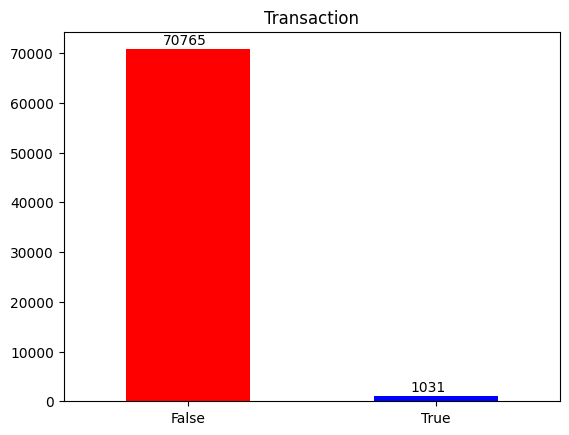

In [127]:
cmap = cm.get_cmap('plasma')
ax = df['transaction'].value_counts().plot.bar(color=['red','blue'])
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.15, p.get_height() + 1000))
plt.xticks([0,1],['False','True'], rotation=0)
plt.title('Transaction')
plt.show()

In [142]:
df.groupby('userId')['transaction'].max().value_counts()

0    60569
1      992
Name: transaction, dtype: int64

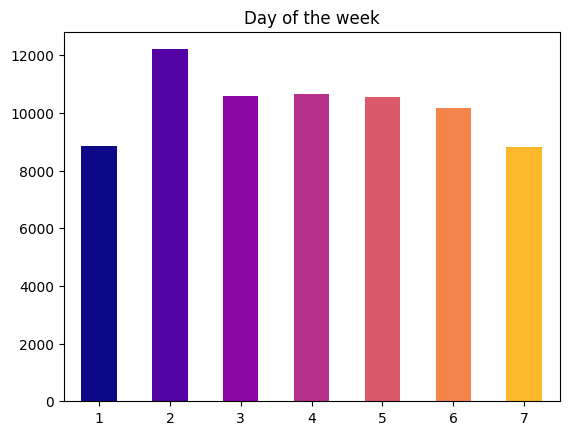

In [9]:
cmap = cm.get_cmap('plasma')
df['weekday'].value_counts().sort_index().plot.bar(color=cmap.colors[::256//7])
plt.xticks(rotation=0)
plt.title('Day of the week')
plt.show()

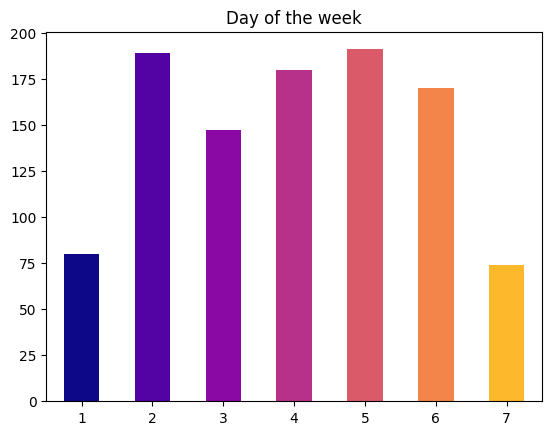

In [29]:
cmap = cm.get_cmap('plasma')
df[df['transaction']==1]['weekday'].value_counts().sort_index().plot.bar(color=cmap.colors[::256//7])
plt.xticks(rotation=0)
plt.title('Day of the week')
plt.show()

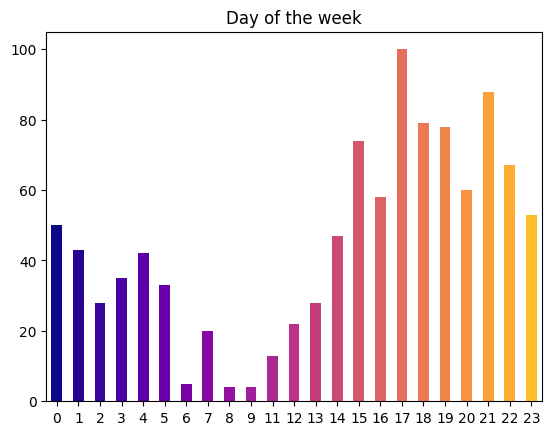

In [108]:
cmap = cm.get_cmap('plasma')
df[df['transaction']==1]['hour'].value_counts().sort_index().plot.bar(color=cmap.colors[::256//24])
plt.xticks(rotation=0)
plt.title('Day of the week')
plt.show()

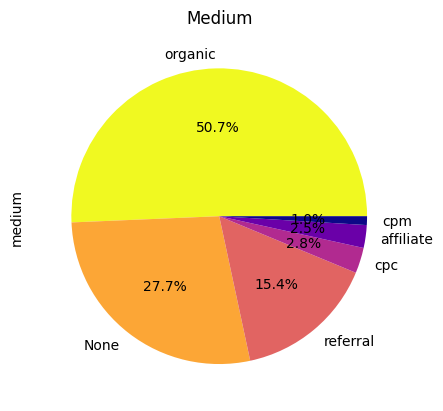

In [71]:
cmap = cm.get_cmap('plasma_r')
df.medium.value_counts(dropna=False).plot.pie(autopct='%1.1f%%', cmap=cmap) #, colors=cmap.colors[::256//6]
plt.xticks(rotation=0)
plt.title('Medium')
plt.show()

In [3]:
df.loc[df['medium'].isin(['(not set)','(none)']), 'medium'] = None # setting these as None

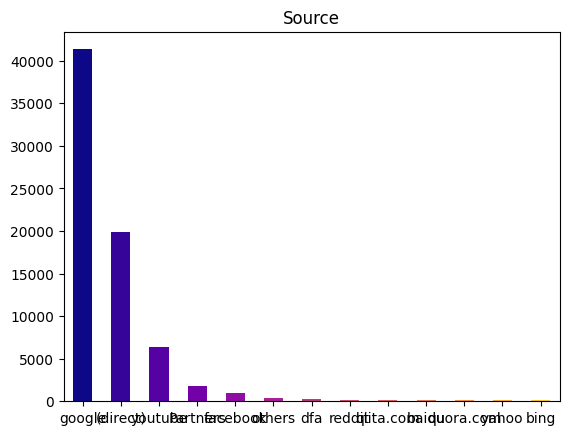

In [95]:
cmap = cm.get_cmap('plasma')
df.source.value_counts().plot.bar(color=cmap.colors[::256//13])
plt.xticks(rotation=0)
plt.title('Source')
plt.show()

In [4]:
df.loc[df.source.str.contains('google'), 'source'] = 'google'
df.loc[df.source.str.contains('yahoo'), 'source'] = 'yahoo'
df.loc[df.source.str.contains('facebook'), 'source'] = 'facebook'
df.loc[df.source.str.contains('youtube'), 'source'] = 'youtube'
df.loc[df.source.str.contains('reddit'), 'source'] = 'reddit'
df.loc[df.source.str.contains('baidu'), 'source'] = 'baidu'
df.loc[df.source.isin(df.source.value_counts()[df.source.value_counts()<100].index), 'source'] = 'others' # grouping occurance less than 100 as others

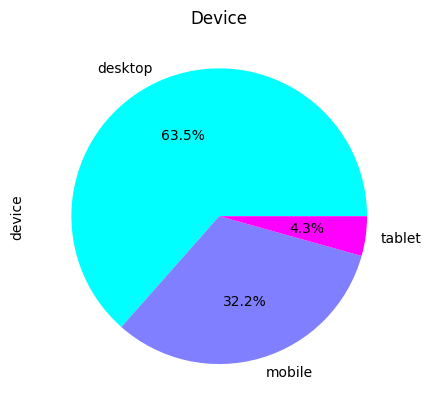

In [60]:
cmap = cm.get_cmap('cool')
df.device.value_counts().plot.pie(autopct='%1.1f%%', cmap=cmap) # colors=cmap.colors[::256//3]
plt.xticks(rotation=0)
plt.title('Device')
plt.show()

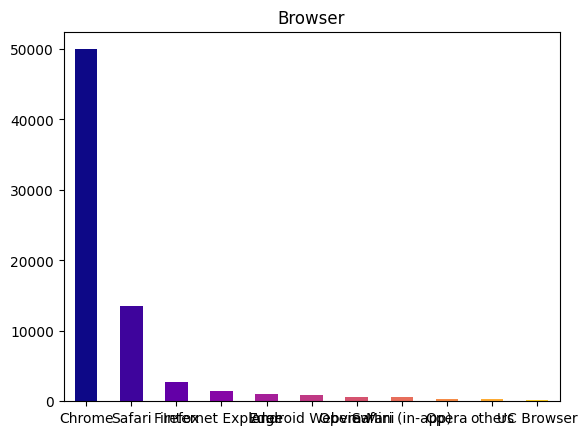

In [99]:
cmap = cm.get_cmap('plasma')
df.browser.value_counts().plot.bar(color=cmap.colors[::256//11])
plt.xticks(rotation=0)
plt.title('Browser')
plt.show()

In [97]:
# df.loc[df['browser']=='(not set)', 'browser'] = '0'
df.loc[df.browser.isin(df.browser.value_counts()[(df.browser.value_counts()<100)].index), 'browser'] = 'others' # grouping occurance less than 100 as others

##### Transaction=1

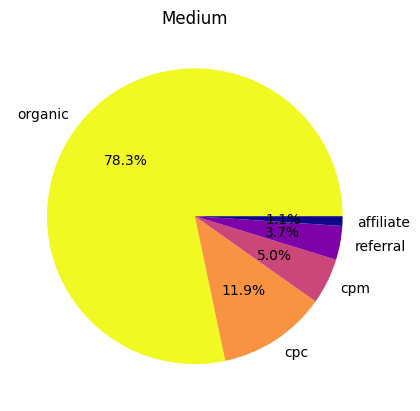

In [104]:
cmap = cm.get_cmap('plasma_r')
df[df['transaction']==1]['medium'].value_counts().plot.pie(autopct='%1.1f%%', cmap=cmap)
plt.xticks(rotation=0)
plt.title('Medium')
plt.ylabel('')
plt.show()

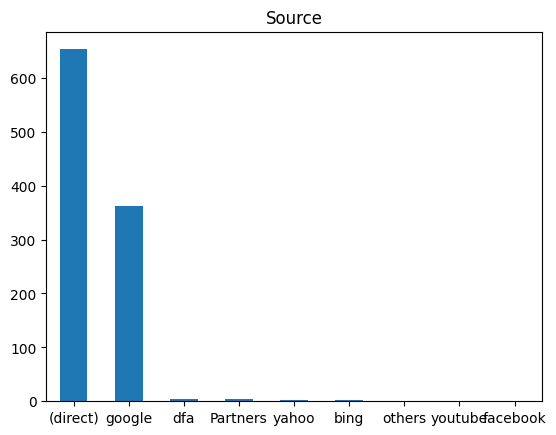

In [96]:
cmap = cm.get_cmap('winter_r')
df[df['transaction']==1]['source'].value_counts().plot.bar()
plt.xticks(rotation=0)
plt.title('Source')
plt.show()

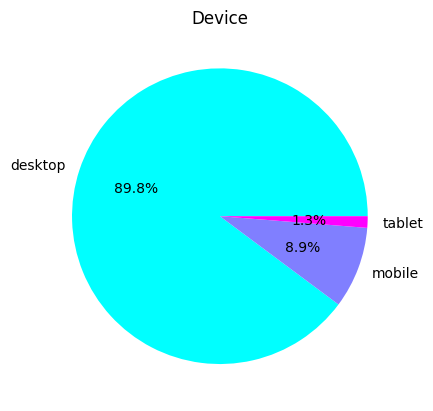

In [105]:
cmap = cm.get_cmap('cool')
df[df['transaction']==1]['device'].value_counts().plot.pie(autopct='%1.1f%%', cmap=cmap)
plt.xticks(rotation=0)
plt.title('Device')
plt.ylabel('')
plt.show()

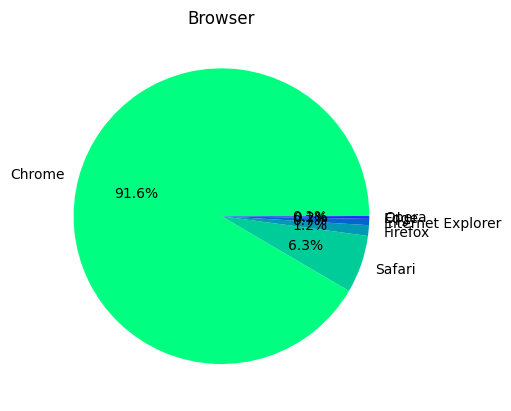

In [106]:
cmap = cm.get_cmap('winter_r')
df[df['transaction']==1]['browser'].value_counts().plot.pie(autopct='%1.1f%%', cmap=cmap)
plt.xticks(rotation=0)
plt.title('Browser')
plt.ylabel('')
plt.show()

### Feature Engineering
This the the only part where I used AI to generate some common categories based on the URLs to group the landing pages. (common practice in marketing) <br>
I also created boolean features to capture whether a user visited the second and third pages.

In [5]:
categories = {
    "apparel": ["women", "wearables", "bags", "zip", "performance", "pullover", "cardigan", "t-shirt", "short sleeve", "blended", "hero", "vest", "jacket", "outerwear", "softshell", "long sleeve", "recycled fabric", "yoga jacket", "recycled tee", 
                "t-shirt", "short sleeve", "hero", "badge", "outerwear", "jacket", "pullover", "vest", "long sleeve", "quilted", "performance", "3x", "rain jacket", "hoodie",
                "kids", "toddler", "short sleeve", "onesie", "infant", "youth", "hoodie", "raglan", "shirt",
                "apparel", "outerwear", "t-shirts", "short sleeve", "long sleeve", "jacket", "performance", "hoodie", "v-neck"],
    "electronics": ["accessories", "charger", "speaker", "bluetooth", "mouse", "flashlight", "selfie stick", "compact", "battery", "power", "plug", "earbuds",
                    "nest", "thermostat", "protect", "learning thermostat", "google", "android",
                    "micro charger", "pocket speaker", "rocket flashlight", "compact charger"],
    "drinkware": ["drinkware", "water bottle", "bottle", "tumblers", "mugs", "insulated", "stainless steel", "tumbler", "sipper", "straw",
                  "22 oz", "25 oz", "20 oz", "24 oz", "mug", "cookie monster mug"],
    "office_supplies": ["office", "writing", "instruments", "notebooks", "journals", "pen", "ballpoint", "journal", "spiral", "leather journal", "writing", "notebooks", "pens", "stick pen", "pen pack", "matching case",
                        "android spiral journal", "google spiral journal", "leather journal", "ballpoint pen"],
    "lifestyle_items": ["accessories", "stickers", "umbrella", "lifestyle", "fun", "sports", "fitness", "pet", "sunglasses", "hand sanitizer", "collapsible bowl", "discs", "yoga mat", "kick ball", "safe flyer",
                        "pet", "collapsible bowl", "feeding mat"
                        "yoga mat", "fitness", "kick ball", "sunglasses"],
    "gift_card": ["gift cards", "cards", "shopping", "bags", "luggage", "home", "housewares", "totes",
                  "gift card", "shopping bag", "water bottles", "collapsible bag", "luggage tag"]
}

In [6]:
def categorize_landingpage(url, categories):
    for key,vals in categories.items():
        for v in vals:
            if v in url:
                return key
    return None

In [7]:
df['landing_categorized'] = df.landingPage.apply(lambda x: categorize_landingpage(x, categories))

In [8]:
df['landing_categorized'].value_counts(dropna=False)

gift_card      35471
electronics    23829
apparel         9432
None            3064
Name: landing_categorized, dtype: int64

In [9]:
df['visitsecondpage'] = None
df['visitthirdpage'] = None

In [10]:
df.loc[df['hitsTimeSecondPage'].isna(), 'visitsecondpage'] = 0
df.loc[df['hitsTimeSecondPage'].notna(), 'visitsecondpage'] = 1
df.loc[df['hitsTimeThirdPage'].isna(), 'visitthirdpage'] = 0
df.loc[df['hitsTimeThirdPage'].notna(), 'visitthirdpage'] = 1

In [11]:
df['visitsecondpage'].value_counts(dropna=False)

0    36533
1    35263
Name: visitsecondpage, dtype: int64

In [12]:
df['visitthirdpage'].value_counts(dropna=False)

0    46569
1    25227
Name: visitthirdpage, dtype: int64

### Encoding
Two types of encodings are used. One hot (categories < 10) and target encodings (categories > 10).

In [13]:
df = pd.get_dummies(df, columns=['medium','device','landing_categorized'])

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71796 entries, 0 to 71795
Data columns (total 31 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   userId                           71796 non-null  object 
 1   sessId                           71796 non-null  object 
 2   newVisitor                       71796 non-null  int64  
 3   visitStartTime                   71796 non-null  int64  
 4   weekday                          71796 non-null  int64  
 5   hour                             71796 non-null  int64  
 6   source                           71796 non-null  object 
 7   browser                          71796 non-null  object 
 8   country                          71796 non-null  object 
 9   region                           71796 non-null  object 
 10  transaction                      71796 non-null  int64  
 11  sessionNumber                    71796 non-null  int64  
 12  landingPage       

In [15]:
for column in ['source','browser']:
    target_mean_map = df.groupby(column)['transaction'].mean().to_dict()
    df[f'{column}_encoded'] = df[column].apply(lambda x: target_mean_map[x])

# Modeling

In [16]:
features = ['newVisitor', 'weekday', 'hour', 'sessionNumber', 'hitTimeLP', 'visitsecondpage', 'visitthirdpage', 'source_encoded', 'browser_encoded','landing_categorized_apparel', 'landing_categorized_electronics', 'landing_categorized_gift_card', 'medium_affiliate', 'medium_cpc', 'medium_cpm', 'medium_organic', 'medium_referral', 'device_desktop', 'device_mobile', 'device_tablet']
target = 'transaction'
df[features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71796 entries, 0 to 71795
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   newVisitor                       71796 non-null  int64  
 1   weekday                          71796 non-null  int64  
 2   hour                             71796 non-null  int64  
 3   sessionNumber                    71796 non-null  int64  
 4   hitTimeLP                        71796 non-null  int64  
 5   visitsecondpage                  71796 non-null  object 
 6   visitthirdpage                   71796 non-null  object 
 7   source_encoded                   71796 non-null  float64
 8   browser_encoded                  71796 non-null  float64
 9   landing_categorized_apparel      71796 non-null  uint8  
 10  landing_categorized_electronics  71796 non-null  uint8  
 11  landing_categorized_gift_card    71796 non-null  uint8  
 12  medium_affiliate  

In [17]:
X = df[features]
y = df[target]

In [18]:
# Split data into train and test at 7:3 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [19]:
# Oversampling with SMOTE
counter = Counter(y_train)
print('Before', counter)

sm = SMOTE(k_neighbors=10, random_state=0)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

counter = Counter(y_train_sm)
print('After', counter)

Before Counter({0: 49528, 1: 729})
After Counter({0: 49528, 1: 49528})


In [107]:
# Random Forest Classifier were used
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train_sm, y_train_sm)

y_train_pred = rf.predict(X_train)
y_train_pred_score = rf.predict_proba(X_train)[:, 1]
y_test_pred = rf.predict(X_test)
y_test_pred_score = rf.predict_proba(X_test)[:, 1]

print('Training Score')
print('precision', round(precision_score(y_train, y_train_pred),2))
print('recall', round(recall_score(y_train, y_train_pred),2))
print('f1 score', round(f1_score(y_train, y_train_pred),2))
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_train_pred_score)
auc_score_train = auc(recall_train, precision_train)
print('auc', round(auc_score_train,2))

print('Test Score')
print('precision', round(precision_score(y_test, y_test_pred),2))
print('recall', round(recall_score(y_test, y_test_pred),2))
print('f1 score', round(f1_score(y_test, y_test_pred),2))
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, y_test_pred_score)
auc_score_test = auc(recall_test, precision_test)
print('auc', round(auc_score_test,2))

Training Score
precision 0.23
recall 0.85
f1 score 0.36
auc 0.46
Test Score
precision 0.08
recall 0.35
f1 score 0.13
auc 0.11


<AxesSubplot: >

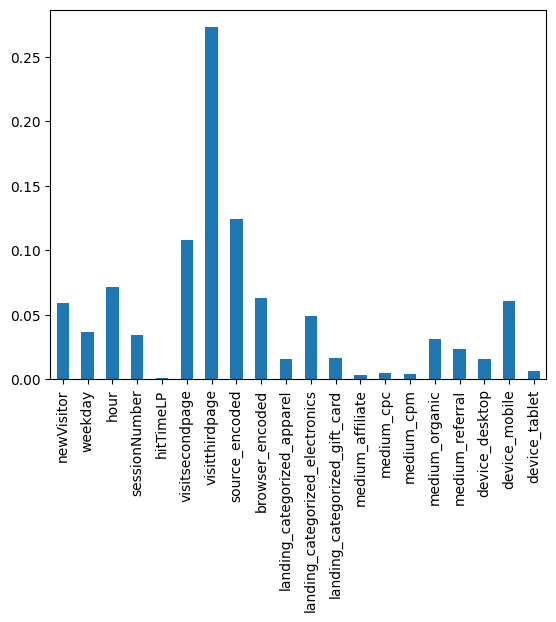

In [25]:
forest_importances = pd.Series(rf.feature_importances_, index=features)
forest_importances.plot.bar()

In [30]:
X

,newVisitor,weekday,hour,sessionNumber,hitTimeLP,visitsecondpage,visitthirdpage,source_encoded,browser_encoded,landing_categorized_apparel,landing_categorized_electronics,landing_categorized_gift_card,medium_affiliate,medium_cpc,medium_cpm,medium_organic,medium_referral,device_desktop,device_mobile,device_tablet
0,1,4,11,1,0,0,0,0.032842,0.018897,0,0,1,0,0,0,0,0,1,0,0
1,0,4,10,2,0,0,0,0.032842,0.018897,0,0,1,0,0,0,0,0,1,0,0
2,1,4,22,1,0,0,0,0.032842,0.018897,0,0,1,0,0,0,0,0,1,0,0
3,1,4,7,1,0,0,0,0.032842,0.018897,0,0,1,0,0,0,0,0,1,0,0
4,1,5,6,1,0,0,0,0.032842,0.004793,0,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71791,0,5,10,7,0,1,1,0.002237,0.018897,0,1,0,1,0,0,0,0,1,0,0
71792,1,5,7,1,0,1,1,0.008759,0.018897,1,0,0,0,0,0,1,0,0,1,0
71793,0,5,15,8,0,1,1,0.002237,0.018897,0,1,0,1,0,0,0,0,1,0,0
71794,1,5,15,1,0,1,1,0.008759,0.018897,1,0,0,0,0,0,1,0,1,0,0


In [94]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(X_train_sm)
X_pca = pca.transform(X_train_sm)

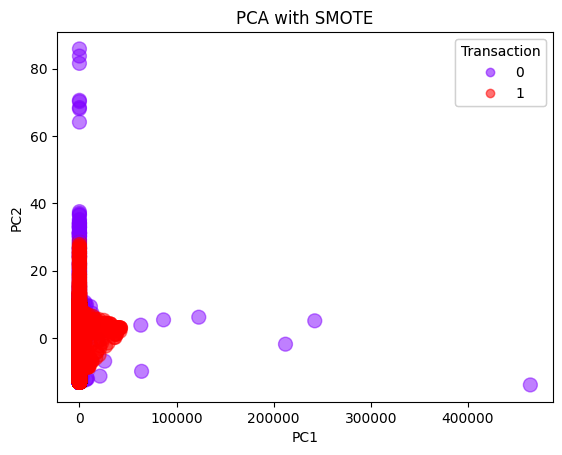

In [98]:
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train_sm, cmap='rainbow', s=100, alpha=0.5)
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="Transaction")
plt.gca().add_artist(legend1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA with SMOTE')
plt.show()

In [99]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(X_train)
X_pca = pca.transform(X_train)

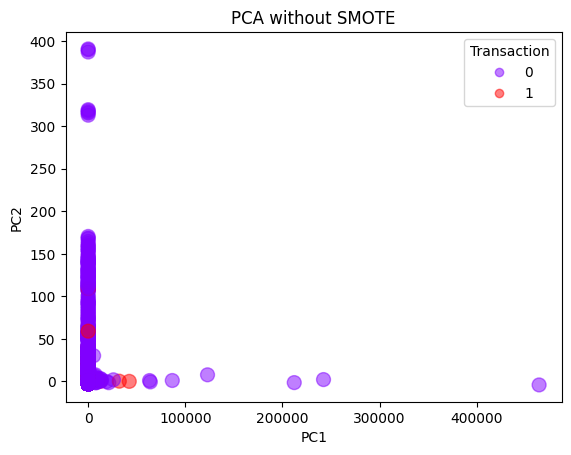

In [100]:
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, s=100, cmap='rainbow', alpha=0.5)
legend1 = plt.legend(*scatter.legend_elements(),
                    loc="upper right", title="Transaction")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA without SMOTE')
plt.show()

In [21]:
precision_score(y_test, y_test_pred_score>0.7)

0.0856269113149847

In [22]:
recall_score(y_test, y_test_pred_score>0.3)

0.4139072847682119

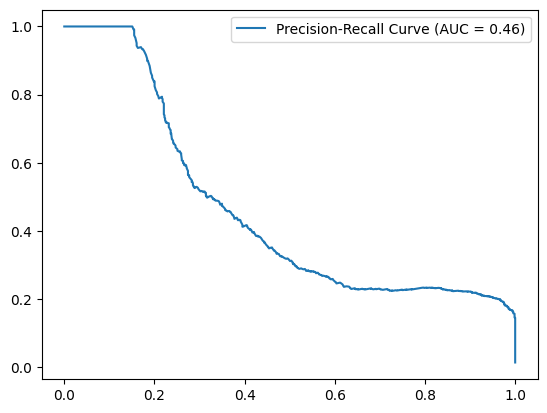

In [45]:
plt.plot(recall_train, precision_train, label=f'Precision-Recall Curve (AUC = {auc_score_train:.2f})')
plt.legend()

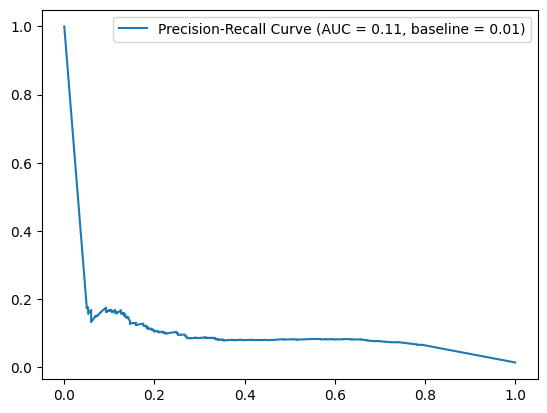

In [46]:
baseline = y_test.value_counts(normalize=True)[1]
plt.plot(recall_test, precision_test, label=f'Precision-Recall Curve (AUC = {auc_score_test:.2f}, baseline = {baseline:.2f})')
plt.legend()

# Comments
Overall, the training score is moderate, with higher recall but lower precision. This indicates that the model is over-predicting the positive (minority) class, even though SMOTE was applied to oversample the minority class and improve decision boundaries. <br>

Steps I'd consider next: <br>

1. Undersample the majority class or apply class weights to ensure the model accounts for the class imbalance during training.
2. Generate more meaningful features, such as mapping countries to continents/GDP, or categorizing regions by income level, or further feature engineering second or third page visits, etc.
3. Implement K-fold cross-validation or assess how the model responds to changes in data size, feature set, and model complexity.
4. If the model overfits, apply techniques like gradient boosting or XGBoost to reduce variance.